Hello everyone,

In this project, it is required to build a classification model for Car Insurance cold calls result (customer buys it or not).
We will work with the [Car Insurance Cold Calls](https://www.kaggle.com/datasets/kondla/carinsurance) dataset.

At first, what are the main steps we should go through in this project?

# TODOs:

1. Understand the problem (look at the big picture)
2. Get and split data
3. Analysis and Visualization
3. Features extraction
3. Model Selection
3. Result

# 1. Understand the problem

This is a dataset from one bank in the United States. this bank also provides car 
insurance services. The bank organizes regular campaigns to attract new clients. The bank has potential 
customers’ data, and bank’s employees call them for advertising available car insurance options. We are 
provided with general information about clients (age, job, etc.) as well as more specific information about the 
current insurance sell campaign (communication, last contact day) and previous campaigns (attributes like 
previous attempts, outcome). 
We have data about customers who were contacted during the last campaign and for whom the results 
of campaign (did the customer buy insurance or not) are known

In [1]:
##################################################### imports #####################################################
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

# 2. Get data

In [2]:
df = pd.read_csv('./dataset/carInsurance_train.csv')
df.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


# 3. Analyzing & Splitting Data 

Here we see the effect of different epsilons and sample sizes on the probability of the error being within these epsilons
    
        The lower the epsilon the more data we need
        where epsilon is the maximum deviation of test error from out of sample error

Where P represents how close the test set can represent the out world:

`P = 1 - P[|Eout - Etest| > e] = P[|Eout - Etest| <= e]`

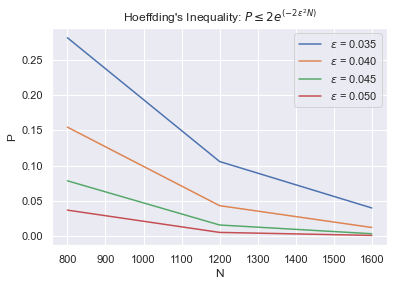

In [3]:
import numpy as np
import math

def hoeffding (x, epsilon):
	y = 2.0 * math.exp (-2*epsilon*epsilon*x)
	return y

# Here we try sample sizes ranging from 2.5% to 17.5%
x = [len(df) * i/100 for i in range(20, 50, 10)]

y1 = [hoeffding (x, 0.035) for x in x]
y2 = [hoeffding (x, 0.040) for x in x]
y3 = [hoeffding (x, 0.045) for x in x]
y4 = [hoeffding (x, 0.050) for x in x]

import matplotlib.pyplot as plt

plt.xlabel ('N')
plt.ylabel ('P')
latex1 = r'P\leq2e^{\left( -2\varepsilon ^{2}N\right)}'
plt.title (r"Hoeffding's Inequality: $ %s $" % latex1)

latext2 = r'\varepsilon'
plt.plot (x, y1, label='$%s$ = 0.035' % latext2)
plt.plot (x, y2, label='$%s$ = 0.040' % latext2)
plt.plot (x, y3, label='$%s$ = 0.045' % latext2)
plt.plot (x, y4, label='$%s$ = 0.050' % latext2)

plt.legend ()
plt.show ()

We will go with test size = 1200, which equals test ratio of 0.3

Here we see the effect of fixing epsilon at 0.15 (max deviation between Etest and Eout) while changing alpha (How certain we want to be that the error is within that epsilon)
    
        The lower the alpha the more data we need where alpha is `1 - P(how certain we want to be)`
        If we want to be 99% certain then alpha is 0.01 

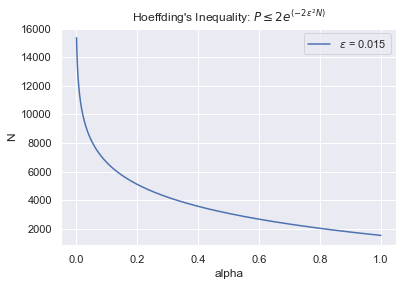

In [4]:
import math
def Hoeffding_SampleSize(error, alpha): 
                          n = (-1//(2 * error**2)) * math.log(alpha/2) 
                          return n

# Here we try alphas ranging from 1 to 0.0001                          
x = [x / 1000 for x in range(1000, 1, -1)]
y = [Hoeffding_SampleSize (0.015, x) for x in x]

import matplotlib.pyplot as plt

plt.ylabel ('N')
plt.xlabel ('alpha')
latex1 = r'P\leq2e^{\left( -2\varepsilon ^{2}N\right)}'
plt.title (r"Hoeffding's Inequality: $ %s $" % latex1)

latext2 = r'\varepsilon'
plt.plot (x, y, label='$%s$ = 0.015' % latext2)

plt.legend ()
plt.show ()


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('CarInsurance', axis=1), df['CarInsurance'], test_size=0.3, random_state=42)

In [6]:
df_train = X_train
df_train['CarInsurance'] = y_train

## Split data with test ratio = 0.3

In [7]:
total_size = len(df)
train_size, test_size = len(y_train), len(y_test)
print(f'total data samples: {total_size} ({total_size/total_size * 100}%)')
print(f'train samples: {train_size} ({round(train_size/total_size, 1) * 100}%)')
print(f'test samples: {test_size} ({round(test_size/total_size, 1) * 100}%)')
print(f'Train Data is free of missing values: {"❌" if X_train.isna().any().any() else "✔"}')

total data samples: 4000 (100.0%)
train samples: 2800 (70.0%)
test samples: 1200 (30.0%)
Train Data is free of missing values: ❌


lets check if the training data has some sort of unbalance.

In [8]:
sum(y_train==0), sum(y_train==1)

(1670, 1130)

There is no umbalance in the data ✔

## Data Analysis

### Outliers

<AxesSubplot:>

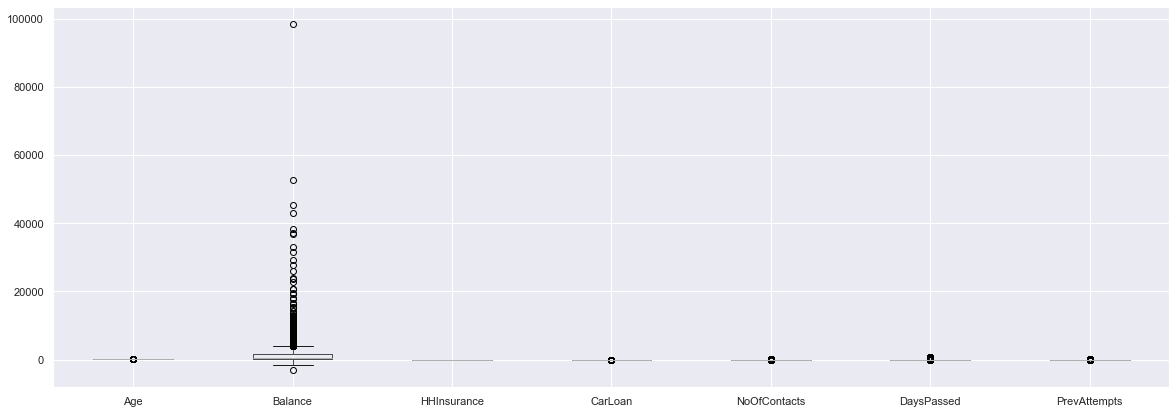

In [9]:
df_train.boxplot(column=list(['Age', 'Balance', 'HHInsurance', 'CarLoan', 'NoOfContacts', 'DaysPassed', 'PrevAttempts']), figsize=(20,7), )

There is an obvious outliers in `Balance`, we are going to drop them

_Before Dropping balance outliers:_

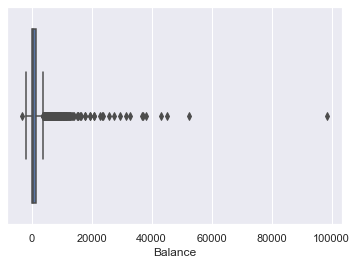

In [10]:
sns.boxplot(x=df_train['Balance'])
plt.show()

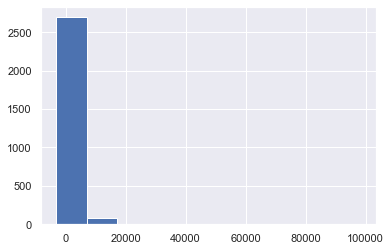

In [11]:
plt.hist(df_train['Balance'])
plt.show()

_After Dropping balance outliers:_

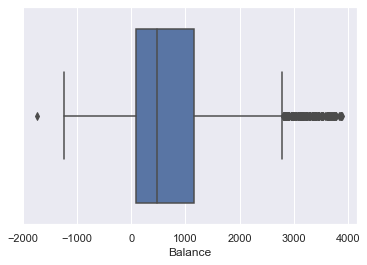

In [12]:
Q1 = np.percentile(a=df_train['Balance'], q=25,
				method = 'midpoint')

Q3 = np.percentile(a=df_train['Balance'], q=75,
				method = 'midpoint')
IQR = Q3 - Q1


df_train = df_train.query('Balance < (@Q3 + 1.5 * @IQR)')
df_train = df_train.query('Balance > (@Q1 - 1.5 * @IQR)')

sns.boxplot(x=df_train['Balance'])
plt.show()

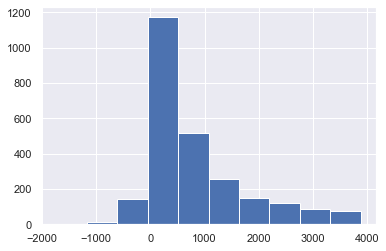

In [13]:
plt.hist(df_train['Balance'])
plt.show()

### Correlation

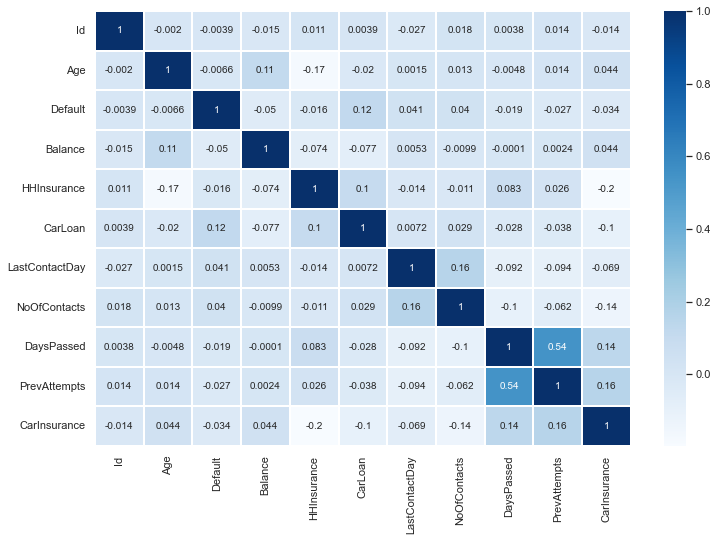

In [14]:
corr = X_train.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, cmap="Blues", annot=True, linewidths=2)
plt.show()

### Extra Plots

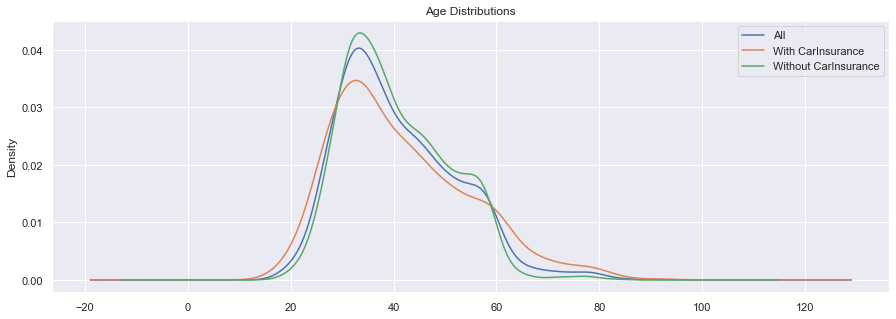

In [15]:
all_ages = df_train['Age'].rename("All", inplace=False)
ages_with_carInsurance = df_train[df_train['CarInsurance']==1]['Age'].rename("With CarInsurance", inplace=False)
ages_without_carInsurance = df_train[df_train['CarInsurance']==0]['Age'].rename("Without CarInsurance", inplace=False)

all_ages.plot(kind='kde', figsize=(15,5))
ages_with_carInsurance.plot(kind='kde', figsize=(15, 5))
ages_without_carInsurance.plot(kind='kde', figsize=(15, 5))
plt.title("Age Distributions")
plt.legend()
plt.show()

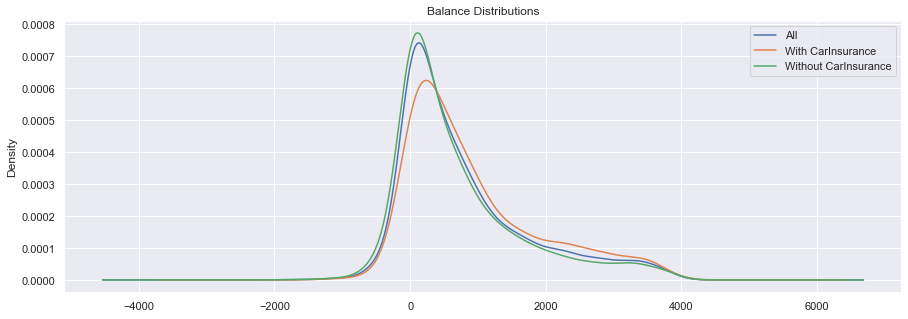

In [16]:
all_balance = df_train['Balance'].rename("All", inplace=False)
balance_with_carInsurance = df_train[df_train['CarInsurance']==1]['Balance'].rename("With CarInsurance", inplace=False)
balance_without_carInsurance = df_train[df_train['CarInsurance']==0]['Balance'].rename("Without CarInsurance", inplace=False)

all_balance.plot(kind='kde', figsize=(15,5))
balance_with_carInsurance.plot(kind='kde', figsize=(15, 5))
balance_without_carInsurance.plot(kind='kde', figsize=(15, 5))
plt.title("Balance Distributions")
plt.legend()
plt.show()

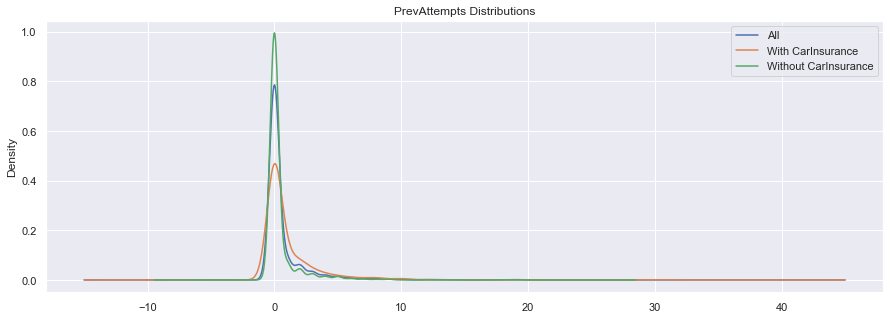

In [17]:
all_PrevAttempts = df_train['PrevAttempts'].rename("All", inplace=False)
PrevAttempts_with_carInsurance = df_train[df_train['CarInsurance']==1]['PrevAttempts'].rename("With CarInsurance", inplace=False)
PrevAttempts_without_carInsurance = df_train[df_train['CarInsurance']==0]['PrevAttempts'].rename("Without CarInsurance", inplace=False)

all_PrevAttempts.plot(kind='kde', figsize=(15,5))
PrevAttempts_with_carInsurance.plot(kind='kde', figsize=(15, 5))
PrevAttempts_without_carInsurance.plot(kind='kde', figsize=(15, 5))
plt.title("PrevAttempts Distributions")
plt.legend()
plt.show()

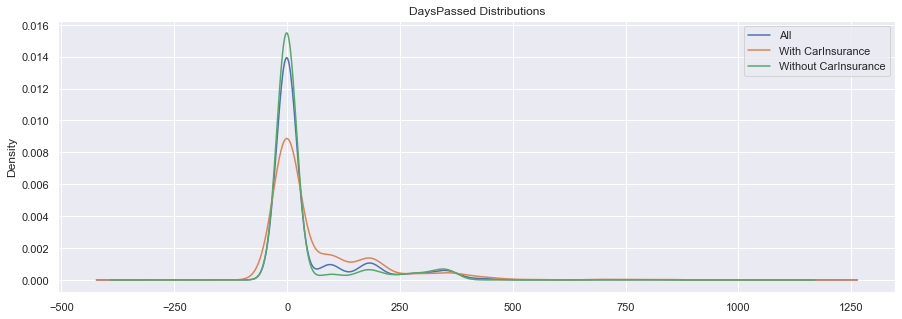

In [18]:
all_DaysPassed = df_train['DaysPassed'].rename("All", inplace=False)
DaysPassed_with_carInsurance = df_train[df_train['CarInsurance']==1]['DaysPassed'].rename("With CarInsurance", inplace=False)
DaysPassed_without_carInsurance = df_train[df_train['CarInsurance']==0]['DaysPassed'].rename("Without CarInsurance", inplace=False)

all_DaysPassed.plot(kind='kde', figsize=(15,5))
DaysPassed_with_carInsurance.plot(kind='kde', figsize=(15, 5))
DaysPassed_without_carInsurance.plot(kind='kde', figsize=(15, 5))
plt.title("DaysPassed Distributions")
plt.legend()
plt.show()

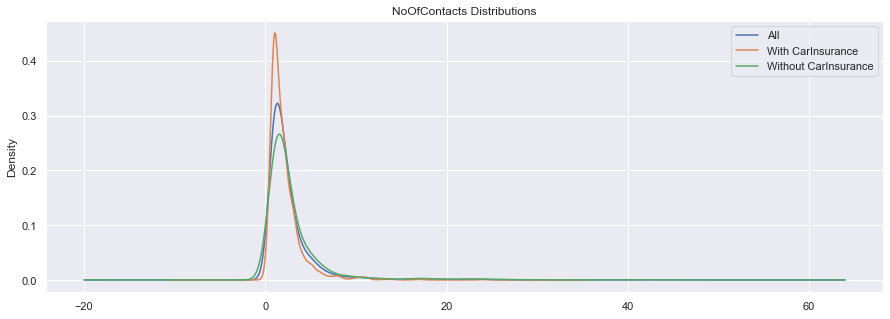

In [19]:
all_NoOfContacts = df_train['NoOfContacts'].rename("All", inplace=False)
NoOfContacts_with_carInsurance = df_train[df_train['CarInsurance']==1]['NoOfContacts'].rename("With CarInsurance", inplace=False)
NoOfContacts_without_carInsurance = df_train[df_train['CarInsurance']==0]['NoOfContacts'].rename("Without CarInsurance", inplace=False)

all_NoOfContacts.plot(kind='kde', figsize=(15,5))
NoOfContacts_with_carInsurance.plot(kind='kde', figsize=(15, 5))
NoOfContacts_without_carInsurance.plot(kind='kde', figsize=(15, 5))
plt.title("NoOfContacts Distributions")
plt.legend()
plt.show()

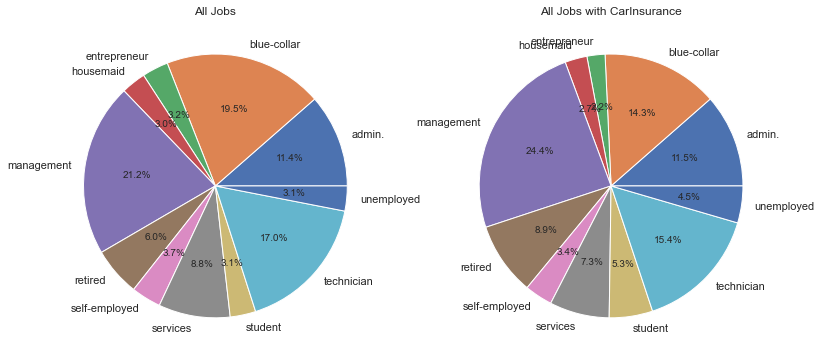

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_train['Job'].value_counts().sort_index().plot(kind='pie', ax=axes[0], figsize=(13,32), autopct='%1.1f%%', title='All Jobs', ylabel='')
df_train[df_train['CarInsurance']==1]['Job'].value_counts().sort_index().plot(kind='pie', ax=axes[1], figsize=(13,32), autopct='%1.1f%%', title='All Jobs with CarInsurance', ylabel='')
plt.show()

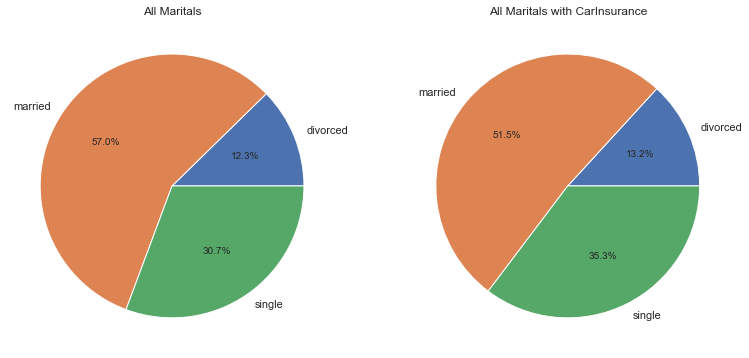

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_train['Marital'].value_counts().sort_index().plot(kind='pie', ax=axes[0], figsize=(13,32), autopct='%1.1f%%', title='All Maritals', ylabel='')
df_train[df_train['CarInsurance']==1]['Marital'].value_counts().sort_index().plot(kind='pie', ax=axes[1], figsize=(13,32), autopct='%1.1f%%', title='All Maritals with CarInsurance', ylabel='')
plt.show()

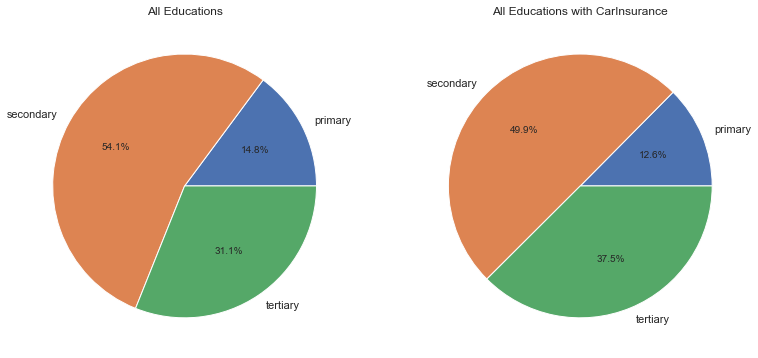

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_train['Education'].value_counts().sort_index().plot(kind='pie', ax=axes[0], figsize=(13,32), autopct='%1.1f%%', title='All Educations', ylabel='')
df_train[df_train['CarInsurance']==1]['Education'].value_counts().sort_index().plot(kind='pie', ax=axes[1], figsize=(13,32), autopct='%1.1f%%', title='All Educations with CarInsurance', ylabel='')
plt.show()

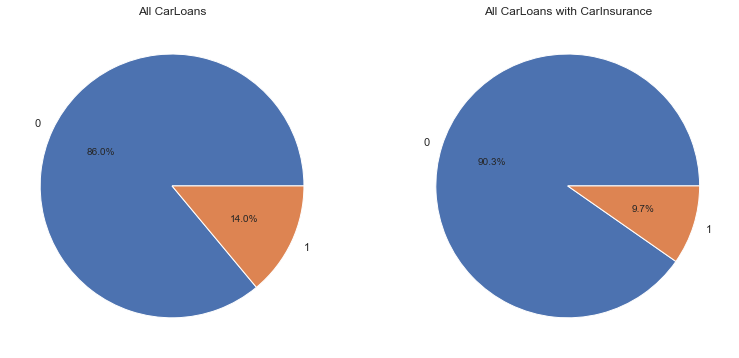

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_train['CarLoan'].value_counts().sort_index().plot(kind='pie', ax=axes[0], figsize=(13,32), autopct='%1.1f%%', title='All CarLoans', ylabel='')
df_train[df_train['CarInsurance']==1]['CarLoan'].value_counts().sort_index().plot(kind='pie', ax=axes[1], figsize=(13,32), autopct='%1.1f%%', title='All CarLoans with CarInsurance', ylabel='')
plt.show()

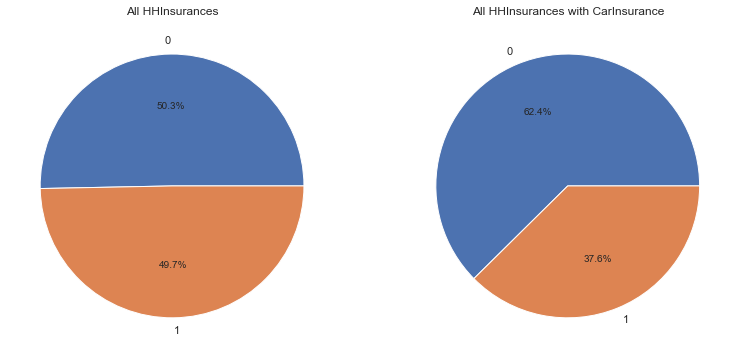

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_train['HHInsurance'].value_counts().sort_index().plot(kind='pie', ax=axes[0], figsize=(13,32), autopct='%1.1f%%', title='All HHInsurances', ylabel='')
df_train[df_train['CarInsurance']==1]['HHInsurance'].value_counts().sort_index().plot(kind='pie', ax=axes[1], figsize=(13,32), autopct='%1.1f%%', title='All HHInsurances with CarInsurance', ylabel='')
plt.show()

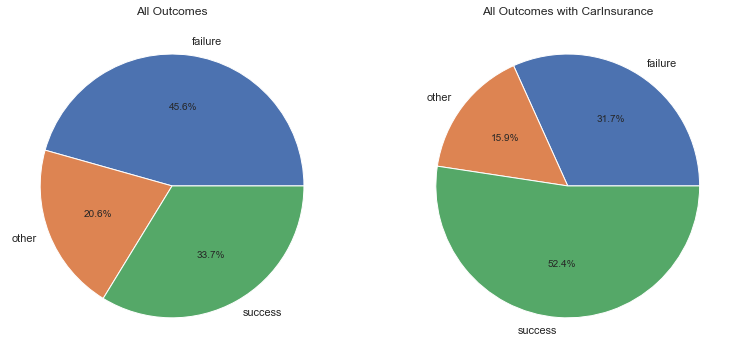

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_train['Outcome'].value_counts().sort_index().plot(kind='pie', ax=axes[0], figsize=(13,32), autopct='%1.1f%%', title='All Outcomes', ylabel='')
df_train[df_train['CarInsurance']==1]['Outcome'].value_counts().sort_index().plot(kind='pie', ax=axes[1], figsize=(13,32), autopct='%1.1f%%', title='All Outcomes with CarInsurance', ylabel='')
plt.show()

In [27]:
X_train = df_train.drop('CarInsurance', axis=1)
y_train = df_train['CarInsurance']

# 3. Preprocessing

## At first, we need to check null values

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

For now, lets drop `Outcome` as it about 75% missing data

and also `Id` as it is useless

In [29]:
def preprocessingDrop(X):
    return X.drop(['Id', 'Outcome'], axis=1, inplace=False)

Then, We need to impute the rest missing data.

All are categorical data, so we will use mode (most-frequent) strategy.

In [30]:
from sklearn.impute import SimpleImputer

tmp = preprocessingDrop(X_train)
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(tmp)

SimpleImputer(strategy='most_frequent')

### Now, we need to encode the categorical features

Some feautures will be easy to encode, it's an ordered data that can be encoded as 0,1,2... as below

In [31]:

def encodeLastContactMonth(X):
    months_dict = {
        'jan':0,
        'feb':1,
        'mar':2,
        'apr':3,
        'may':4,
        'jun':5,
        'jul':6,
        'aug':7,
        'sep':8,
        'oct':9,
        'nov':10,
        'dec':11
    }

    X = X.copy()
    X['LastContactMonth'] = X['LastContactMonth'].replace(months_dict)
    return X

def encodeCommunication(X):
    X = X.copy()
    X['Communication'] = X['Communication'].replace({'telephone':0, 'cellular':1})
    return X
    
def encodeMarital(X):
    X = X.copy()
    X['Marital'] = X['Marital'].replace({'divorced':0, 'single':1, 'married':2})
    return X

def encodeEducation(X):
    X = X.copy()
    X['Education'] = X['Education'].replace({'primary':0, 'secondary':1, 'tertiary':2})
    return X

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2530 entries, 3215 to 3174
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                2530 non-null   int64 
 1   Age               2530 non-null   int64 
 2   Job               2517 non-null   object
 3   Marital           2530 non-null   object
 4   Education         2411 non-null   object
 5   Default           2530 non-null   int64 
 6   Balance           2530 non-null   int64 
 7   HHInsurance       2530 non-null   int64 
 8   CarLoan           2530 non-null   int64 
 9   Communication     1966 non-null   object
 10  LastContactDay    2530 non-null   int64 
 11  LastContactMonth  2530 non-null   object
 12  NoOfContacts      2530 non-null   int64 
 13  DaysPassed        2530 non-null   int64 
 14  PrevAttempts      2530 non-null   int64 
 15  Outcome           572 non-null    object
 16  CallStart         2530 non-null   object
 17  CallEnd    

Others will be more tricky, as `Job`, we can encode is as one-hot vector

In [33]:
len(X_train.Job.unique()), X_train.Job.unique()

(12,
 array(['technician', 'admin.', 'blue-collar', 'self-employed',
        'management', 'retired', 'entrepreneur', 'student', 'services',
        'housemaid', 'unemployed', nan], dtype=object))

But the downside is we are going to have `n-1=11` columns to just encode it.

Lets try it

In [34]:
from sklearn.preprocessing import LabelBinarizer

jobs_available = X_train['Job'].unique()
# remove nans from the list
jobs_available= list(filter(lambda v: v==v, jobs_available))
# fit enocder
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(jobs_available)

LabelBinarizer()

Another solution would be encoding them in order, in here we will order them according to the balance variance as balance mean ~ zero for each job

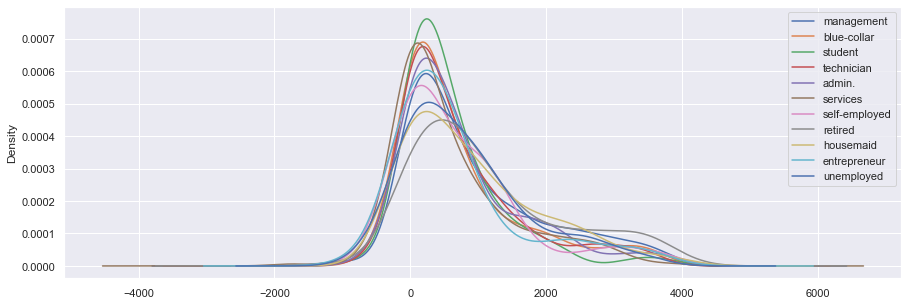

In [35]:
for job in df.Job.unique():
    if type(job)==str:
        X_train[X_train['Job']==job]['Balance'].rename(job, inplace=False).plot(kind='kde', figsize=(15,5))

plt.legend()

In [36]:
k = {}
for job in df.Job.unique():
    if type(job)==str:
        
        k[job] = X_train[X_train['Job']==job]['Balance'].var()


In [37]:
sorted(k.items(), key=lambda x: x[1], reverse=True)

[('retired', 1217180.5306935124),
 ('management', 1040917.9213131802),
 ('housemaid', 950610.2222807017),
 ('entrepreneur', 911508.3225308642),
 ('blue-collar', 881874.7159815454),
 ('self-employed', 876419.3803153367),
 ('technician', 824199.8603164875),
 ('admin.', 813050.7150479094),
 ('unemployed', 808825.1742993848),
 ('services', 772159.1468120116),
 ('student', 542349.3024991887)]

In [38]:
def encodeJob(X):
    job_dict = {
        'housemaid':0,
        'services':1,
        'admin.':2,
        'blue-collar':3,
        'unemployed':4,
        'technician':5,
        'student':6,
        'entrepreneur':7,
        'retired':8,
        'management':9,
        'self-employed':10,
    }
    X = X.copy()
    X['Job'] = X['Job'].replace(job_dict, inplace=False)
    return X

And for Calls, we will calculate the call duration and drop CallEnd.

As the time of starting the call call may be an important factor beside how long the call took.

In [39]:
def preprocessCallTime(X):
    X = X.copy()
    X['CallEnd'] = pd.to_datetime(X['CallEnd'],  infer_datetime_format=True)
    X['CallStart'] = pd.to_datetime(X['CallStart'],  infer_datetime_format=True)
    X['CallDuration'] = X['CallEnd'] - X['CallStart']    
    X['CallDuration'] = (X['CallDuration'].values.astype(np.longlong)/1e9).astype(int)
    X['CallStart'] = X['CallStart'].apply(lambda x: int(x.strftime("%H")))
    X.drop('CallEnd', axis=1, inplace=True)
    return X

Now Let's put all together in one function

In [40]:
def preprocessing(X, job_hot_encoding=False):
    # Deep copy first
    
    X = X.copy()
    # Drop unwanted columns
    X = preprocessingDrop(X)

    # Imputer
    col, idx = X.columns, X.index
    X = pd.DataFrame(imputer.transform(X))
    X.columns, X.index = col, idx
    
    # Simple One column encoding
    X = encodeLastContactMonth(X)
    X = encodeCommunication(X)
    X = encodeMarital(X)
    X = encodeEducation(X)

    # Feature Calculation
    X = preprocessCallTime(X)

    # Job Hot-Vector
    if job_hot_encoding:
        transformed = jobs_encoder.transform(X['Job'])
        ohe_df = pd.DataFrame(transformed, columns=jobs_encoder.classes_)
        ohe_df.index = X.index
        X = pd.concat([X, ohe_df], axis=1).drop('Job', axis=1)
    else:
        X = encodeJob(X)
    return X




In [41]:
from statistics import median
from sklearn.model_selection import cross_val_score

def cross_val_classifiers(X, Y, clfs, labels=None):
    scores = []
    best_median_score = 0
    for i in range(len(clfs)):
        score = cross_val_score(clfs[i], X, Y)
        scores.append(score)
        m = median(score)
        if m > best_median_score:
            best_median_score = m
    
    if labels is None:
        labels = clfs
        
    scores_df = pd.DataFrame(columns=labels, data=np.array(scores).T)
    return scores_df

In [42]:
from statistics import median
from sklearn.model_selection import cross_val_score

def cross_val_classifiers(X, Y, clfs, labels=None):
    scores = []
    best_median_score = 0
    for i in range(len(clfs)):
        score = cross_val_score(clfs[i], X, Y)
        scores.append(score)
        m = median(score)
        if m > best_median_score:
            best_median_score = m
    
    if labels is None:
        labels = clfs
        
    scores_df = pd.DataFrame(columns=labels, data=np.array(scores).T)
    return scores_df

Cross validation without `job` hot encoded

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


X_job_o = preprocessing(X_train, job_hot_encoding=False)
cross_val_classifiers(X_job_o, y_train, [RandomForestClassifier(), GaussianNB()], labels=None)

,RandomForestClassifier(),GaussianNB()
0,0.820158,0.747036
1,0.841897,0.750988
2,0.818182,0.750988
3,0.839921,0.774704
4,0.863636,0.754941


Cross Validation with `job` hot encodeing

In [44]:
X_job_he = preprocessing(X_train, job_hot_encoding=True)
cross_val_classifiers(X_job_he, y_train, [RandomForestClassifier(), GaussianNB()], labels=None)

,RandomForestClassifier(),GaussianNB()
0,0.822134,0.709486
1,0.833992,0.721344
2,0.814229,0.743083
3,0.843874,0.739130
4,0.851779,0.727273


> Hot encoding didn't increase accuracy, so we will stick with the order encoding for `job`.

In [45]:
X_preprocessed = X_job_o

# 4. Model Selection

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

names = [
    "K Nearest Neighbors",
    "RBF SVM",
    "Poly SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="rbf", random_state=42),
    SVC(kernel="poly", random_state=42),
    SVC(kernel="sigmoid", random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
]


In [47]:
cross_val_classifiers(X_preprocessed, y_train, clfs=classifiers, labels=names)

c:\Users\saadm\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\saadm\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

,K Nearest Neighbors,RBF SVM,Poly SVM,Sigmoid SVM,Decision Tree,Random Forest,LogisticRegression,AdaBoost,Naive Bayes
0,0.758893,0.752964,0.691700,0.590909,0.780632,0.816206,0.794466,0.818182,0.747036
1,0.735178,0.715415,0.691700,0.584980,0.790514,0.843874,0.780632,0.833992,0.750988
2,0.766798,0.772727,0.707510,0.614625,0.780632,0.808300,0.790514,0.812253,0.750988
3,0.766798,0.760870,0.705534,0.612648,0.780632,0.843874,0.784585,0.816206,0.774704
4,0.754941,0.768775,0.689723,0.569170,0.750988,0.851779,0.796443,0.818182,0.754941


## Grid Search To get best params

In [48]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [i for i in range(100, 800, 100)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion' :['entropy', 'gini']
}

CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, n_jobs=-1)
CV_rfc.fit(X_preprocessed, y_train)


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700]})

In [49]:
rf_best_params = CV_rfc.best_params_

In [50]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "learning_rate": [0.5, 1],
    "n_estimators": [i for i in range(100, 800, 100)],
    "algorithm" : ["SAMME", "SAMME.R"],
    "base_estimator":[None, DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42)]
    }


CV_adaboost = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid=param_grid, n_jobs=-1)

CV_adaboost.fit(X_preprocessed, y_train)


GridSearchCV(estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator': [None,
                                            DecisionTreeClassifier(random_state=42),
                                            RandomForestClassifier(random_state=42)],
                         'learning_rate': [0.5, 1],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700]})

In [51]:
ab_best_params = CV_adaboost.best_params_

In [52]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'sigmoid', 'poly']
    }


CV_svm = GridSearchCV(SVC(random_state=42), param_grid=param_grid, n_jobs=-1)

CV_svm.fit(X_preprocessed, y_train)


In [ ]:
svm_best_params = CV_svm.best_params_

In [ ]:
score_all = cross_val_classifiers(X_preprocessed, y_train, [
    RandomForestClassifier(random_state=42),
    RandomForestClassifier(random_state=42).set_params(**rf_best_params),
    AdaBoostClassifier(random_state=42),
    AdaBoostClassifier(random_state=42).set_params(**ab_best_params),
    SVC(random_state=42),
    SVC(random_state=42).set_params(**svm_best_params),
    ], ["Default Random Forest", "Best Params Random Forest", "Default Adaboost",  "Best Params Adaboost", "Default SVM",  "Best Params SVM"])

In [ ]:
score_all

,Default Random Forest,Best Params Random Forest,Default Adaboost,Best Params Adaboost,Default SVM,Best Params SVM
0,0.825000,0.835714,0.816071,0.819643,0.737500,0.735714
1,0.828571,0.832143,0.828571,0.823214,0.717857,0.735714
2,0.817857,0.841071,0.810714,0.817857,0.733929,0.758929
3,0.839286,0.850000,0.798214,0.844643,0.744643,0.746429
4,0.833929,0.844643,0.825000,0.844643,0.760714,0.750000


## Run on Test Data

In [ ]:
from sklearn.metrics import classification_report

CV_rfc.score(preprocessing(X_test), y_test)
print('RandomForest on train data')
predicted_classes = CV_rfc.predict(X_train.values)
pd.DataFrame(classification_report(y_train, predicted_classes, output_dict=True))


0.8369047619047619

In [ ]:
CV_adaboost.score(preprocessing(X_test), y_test)
print('Adaboost on train data')
predicted_classes = CV_rfc.predict(X_train.values)
pd.DataFrame(classification_report(y_train, predicted_classes, output_dict=True))


0.8380952380952381

In [ ]:
CV_svm.score(preprocessing(X_test), y_test)
print('Adaboost on train data')
predicted_classes = CV_rfc.predict(X_train.values)
pd.DataFrame(classification_report(y_train, predicted_classes, output_dict=True))


0.7511904761904762